In [1]:
!pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 15.3 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:010:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 6.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 307.6 kB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 203.8 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━

In [2]:
# Standard libraries
import os
import warnings
import math
import random
from pathlib import Path
from collections import Counter, OrderedDict
from typing import List, Tuple, Dict, Optional, Union, Callable
from enum import IntEnum

# Third-party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from tqdm import tqdm
from ipywidgets import interact

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset

# Torchvision
import torchvision.transforms as transforms

# Flower
import flwr
from flwr.client import Client, ClientApp
from flwr.common import (
    Code, EvaluateIns, EvaluateRes, FitIns, FitRes, GetParametersIns, GetParametersRes,
    Status, Parameters, Scalar, NDArray, NDArrays, ndarrays_to_parameters, parameters_to_ndarrays, Context
)
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy import Strategy
from flwr.simulation import run_simulation

# HuggingFace Datasets
from datasets.utils.logging import disable_progress_bar, set_verbosity_error

2025-05-07 04:13:04.303057: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746591184.486318      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746591184.539574      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Thiết lập thiết bị
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()
set_verbosity_error()
warnings.filterwarnings("ignore")

Training on cuda
Flower 1.18.0 / PyTorch 2.5.1+cu124


In [152]:
# Hằng số
NUM_CLIENTS = 10
NUM_ROUNDS = 5
SAMPLE = 'age' # [age, dirichlet]
# Định nghĩa drop out
class CustomCode(IntEnum):
    DROPPED_OUT = 100

# Data Preparation

In [5]:
data_dir = '/kaggle/input/mri-dataset/datasetzip/not_skull_stripped'
label_path = list(Path(data_dir).glob("*.xlsx"))
label_ls = pd.read_excel(label_path[0])
label_ls

,subject_age,subject_dx,subject_sex,subject_id,dataset_name
0,55.4,pathology,m,sub-BrainAge000000,ABIDE/Caltech
1,22.9,pathology,m,sub-BrainAge000001,ABIDE/Caltech
2,39.2,pathology,m,sub-BrainAge000002,ABIDE/Caltech
3,22.8,pathology,m,sub-BrainAge000003,ABIDE/Caltech
4,34.6,pathology,f,sub-BrainAge000004,ABIDE/Caltech
...,...,...,...,...,...
23209,66,control,f,sub-BrainAge023209,RocklandSample
23210,69,control,m,sub-BrainAge023210,RocklandSample
23211,23,control,m,sub-BrainAge023211,RocklandSample
23212,54,control,f,sub-BrainAge023212,RocklandSample


In [6]:
label_ls = label_ls[(label_ls['subject_dx'] == 'control') & ((label_ls['subject_sex'] == 'm') | (label_ls['subject_sex'] == 'f'))]
len(label_ls)

8764

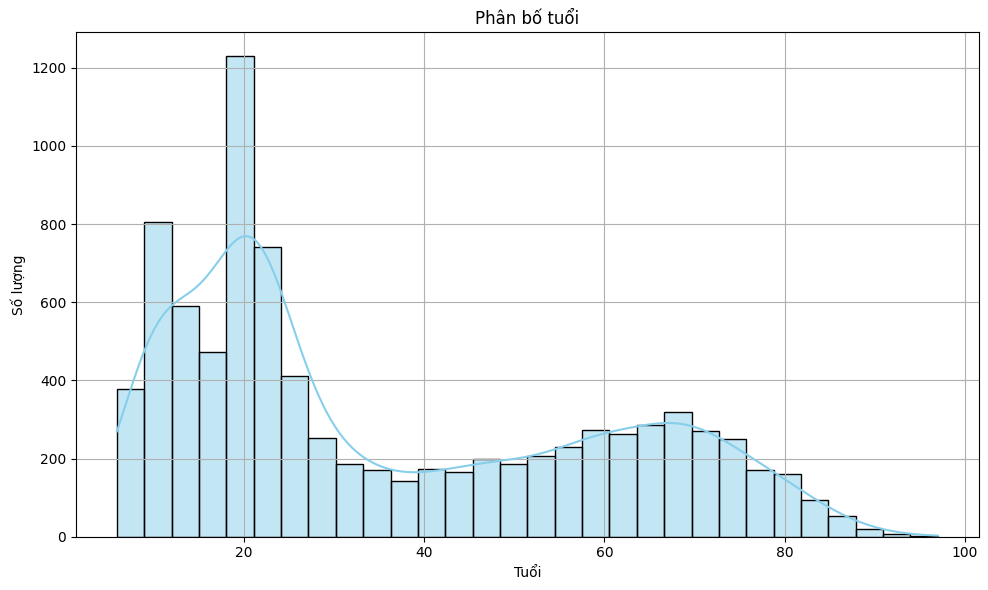

In [7]:
label_ls['subject_age'] = pd.to_numeric(label_ls['subject_age'], errors='coerce')

# Loại bỏ các dòng có giá trị NaN sau khi chuyển đổi
label_ls = label_ls.dropna(subset=['subject_age'])

# Vẽ biểu đồ phân bố tuổi
plt.figure(figsize=(10, 6))
sns.histplot(label_ls['subject_age'], bins=30, kde=True, color='skyblue')
plt.title('Phân bố tuổi')
plt.xlabel('Tuổi')
plt.ylabel('Số lượng')
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
subject_metadata = label_ls[['subject_sex','subject_id','dataset_name','subject_age']]
subject_metadata

,subject_sex,subject_id,dataset_name,subject_age
19,m,sub-BrainAge000019,ABIDE/Caltech,44.2
20,m,sub-BrainAge000020,ABIDE/Caltech,39.3
21,m,sub-BrainAge000021,ABIDE/Caltech,42.5
22,m,sub-BrainAge000022,ABIDE/Caltech,19.7
23,f,sub-BrainAge000023,ABIDE/Caltech,20.0
...,...,...,...,...
23209,f,sub-BrainAge023209,RocklandSample,66.0
23210,m,sub-BrainAge023210,RocklandSample,69.0
23211,m,sub-BrainAge023211,RocklandSample,23.0
23212,f,sub-BrainAge023212,RocklandSample,54.0


In [9]:
subject_metadata_dict = label_ls.set_index('subject_id')[['subject_sex','dataset_name','subject_age']].to_dict(orient='index')
len(subject_metadata_dict)

8717

In [10]:
class MRIDataset(Dataset):
    def __init__(self, im_dir, label_ls, transform=None, im_filenames=None):
        self.im_dir = Path(im_dir)
        self.label_ls = label_ls
        self.transform = transform

        if im_filenames is not None:
            self.im_filenames = im_filenames
        else:
            self.im_filenames = self._gather_valid_paths()

    def _gather_valid_paths(self):
        paths = self.im_dir.glob("*/*/*/*.nii")
        valid_paths = []
        fail_paths = {
            self.im_dir / "sub-BrainAge005600/anat/sub-BrainAge005600_T1w.nii/sub-BrainAge005600_T1w.nii"
        }

        for path in paths:
            if not path.is_file():
                continue
                
            if path in fail_paths:
                continue
                
            subject_id = self._extract_subject_id(path)
            if subject_id not in self.label_ls:
                continue
            try:
                # nib.load(path).get_fdata()
                nib.load(path)
                valid_paths.append(path)
            except Exception:
                continue
        return valid_paths

    def _extract_subject_id(self, path):
        for part in Path(path).parts:
            if part.startswith("sub-BrainAge"):
                return part  # ví dụ: "sub-BrainAge000000"
        return None

    def _normalize(self, im):
        im = (im - np.min(im)) / (np.max(im) - np.min(im) + 1e-5)
        return im.astype(np.float32)

    def _get_label(self, subject_id):
        sex = self.label_ls.get(subject_id, {}).get("subject_sex")
        if sex == 'm':
            return 0
        elif sex == 'f':
            return 1
        else:
            raise ValueError(f"Invalid label for subject {subject_id}: {sex}")
            
    def _get_age(self, subject_id):
        return self.label_ls.get(subject_id, {}).get("subject_age")
    
    def __len__(self):
        return len(self.im_filenames)

    def __getitem__(self, idx):
        im_path = self.im_filenames[idx]
        subject_id = self._extract_subject_id(im_path)

        im = nib.load(im_path).get_fdata()
        im = self._normalize(im)

        label = self._get_label(subject_id)
        image = torch.from_numpy(im).unsqueeze(0)  # Shape: (1, H, W, D)

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)
        
    def num_classes(self):
        class_set = set()
        for idx in range(len(self)):
            _, label = self[idx]
            class_set.add(label.item())
        return len(class_set)    

In [11]:
def get_sample_data(data: MRIDataset, num_samples: int) -> list:
    subject_metadata = data.label_ls

    subject_ids = [data._extract_subject_id(path) for path in data.im_filenames]
    age_array = np.array(
        [subject_metadata.get(sid, {}).get("subject_age", np.nan) for sid in subject_ids],
        dtype=np.float32
    )

    valid_mask = ~np.isnan(age_array)
    valid_indices = np.arange(len(data.im_filenames))[valid_mask]
    age_array = age_array[valid_mask]

    # Phân bins theo độ tuổi
    bins = [0, 20, 30, 40, 50, 60, 70, 80, 100]
    age_bins = np.digitize(age_array, bins, right=False)
    unique_bins = np.unique(age_bins)

    bin_counts = np.bincount(age_bins, minlength=max(unique_bins)+1)[1:]
    age_dist = bin_counts / bin_counts.sum()

    sampled_indices = []
    for bin_id, dist in zip(range(1, len(age_dist)+1), age_dist):
        bin_valid_indices = valid_indices[age_bins == bin_id]
        bin_sample_count = int(num_samples * dist)
        bin_sample_count = min(len(bin_valid_indices), bin_sample_count)
        if bin_sample_count > 0:
            chosen = np.random.choice(bin_valid_indices, size=bin_sample_count, replace=False)
            sampled_indices.extend(chosen)

    return sampled_indices

In [12]:
# sample theo tuoi
def load_client_datasets(partition_id: int, num_partitions: int, dataset, num_samples: int):
    data = dataset
    sampled_indices = get_sample_data(data, num_samples)

    np.random.shuffle(sampled_indices)
    train_size = int(0.8 * len(sampled_indices))
    train_indices = sampled_indices[:train_size]
    val_indices = sampled_indices[train_size:]

    train_subset = Subset(data, train_indices)
    val_subset = Subset(data, val_indices)
    return train_subset, val_subset

In [133]:
from collections import defaultdict

def get_label_indices(dataset):
    label_to_indices = defaultdict(list)
    for idx in range(len(dataset)):
        _, label = dataset[idx]
        label = label.item()  # Convert from tensor to int
        label_to_indices[label].append(idx)
    return label_to_indices
    
def load_datasets(dataset, targets, num_classes, partition_id: int, num_partitions: int, alpha: float = 0.7):
    total_indices = np.arange(targets)  # For test set creation

    # Get indices per class
    indices_per_class = [np.where(labels == i)[0] for i in range(num_classes)]

    # Sample indices for each client using Dirichlet distribution
    np.random.seed(42)
    client_indices = defaultdict(list)

    for c in range(num_classes):
        class_indices = indices_per_class[c]
        np.random.shuffle(class_indices)

        proportions = np.random.dirichlet(np.repeat(alpha, num_partitions))
        proportions = np.clip(proportions, 1e-6, None)  # Avoid zeros
        proportions /= proportions.sum()  # Re-normalize

        split_sizes = (proportions * len(class_indices)).astype(int)

        # Fix rounding errors
        while split_sizes.sum() < len(class_indices):
            split_sizes[np.argmin(split_sizes)] += 1
        while split_sizes.sum() > len(class_indices):
            split_sizes[np.argmax(split_sizes)] -= 1

        splits = np.split(class_indices, np.cumsum(split_sizes)[:-1])

        for i, split in enumerate(splits):
            client_indices[i].extend(split)

    # Get this client’s data
    this_client_indices = client_indices[partition_id]
    if len(this_client_indices) == 0:
        raise ValueError(f"Client {partition_id} has no data assigned. Try increasing alpha.")
    
    np.random.shuffle(this_client_indices)

    # Train split
    trainset = Subset(dataset, this_client_indices)
    trainloader = DataLoader(trainset, batch_size=32, shuffle=True)

    # Test set: all data not used for training by this client
    used_indices = set(this_client_indices)
    val_indices = [i for i in total_indices if i not in used_indices]
    valset = Subset(dataset, val_indices)

    return trainset, valset

In [134]:
targets = get_label_indices(dataset)

In [135]:
def load_server_test_datasets(data: MRIDataset):
    testloader = DataLoader(data, batch_size=8, shuffle=False)
    return testloader

In [136]:
import json

def load_filenames(input_path):
    input_path = Path(input_path)
    if not input_path.is_file():
        raise FileNotFoundError(f"File {input_path} không tồn tại")
    with open(input_path, 'r') as f:
        return [Path(path) for path in json.load(f)]

In [137]:
im_filenames = load_filenames("/kaggle/input/mri-dataset/mri_dataset.json")

In [138]:
dataset = MRIDataset(data_dir, subject_metadata_dict, im_filenames = im_filenames)
len(dataset)

4948

In [139]:
def save_filenames(im_filenames, output_path):
    output_path = Path(output_path)
    output_path.parent.mkdir(parents=True, exist_ok=True)
    with open(output_path, 'w') as f:
        json.dump([str(path) for path in im_filenames], f)
    print(f"Đã lưu im_filenames vào: {output_path}")

In [140]:
save_filenames(dataset.im_filenames, "mri_dataset.json")

Đã lưu im_filenames vào: mri_dataset.json


In [141]:
from sklearn.model_selection import train_test_split
import random

def create_datasets(dataset, sample_fraction=1.0, test_size=0.2, seed=42):
    """
    Create train and test MRIDataset objects, with optional sampling.

    Args:
        dataset (MRIDataset): The full dataset instance.
        sample_fraction (float): Fraction of data to sample from the full dataset (0.0–1.0).
        test_size (float): Fraction of data to use for testing.
        seed (int): Random seed for reproducibility.

    Returns:
        trainset (MRIDataset), testset (MRIDataset)
    """
    assert 0 < sample_fraction <= 1.0, "sample_fraction must be in (0, 1]"

    # Sample a fraction from the full set
    all_filenames = dataset.im_filenames
    num_to_sample = int(len(all_filenames) * sample_fraction)

    if sample_fraction < 1.0:
        random.seed(seed)
        sampled_filenames = random.sample(all_filenames, num_to_sample)
    else:
        sampled_filenames = all_filenames

    # Train-test split on sampled data
    train_filenames, test_filenames = train_test_split(
        sampled_filenames, test_size=test_size, random_state=seed, shuffle=True
    )

    trainset = MRIDataset(
        im_dir=dataset.im_dir,
        label_ls=dataset.label_ls,
        transform=dataset.transform,
        im_filenames=train_filenames
    )

    testset = MRIDataset(
        im_dir=dataset.im_dir,
        label_ls=dataset.label_ls,
        transform=dataset.transform,
        im_filenames=test_filenames
    )

    return trainset, testset

# Model

In [153]:
class _DenseLayer(nn.Sequential):

    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
        super().__init__()
        self.add_module('norm1', nn.BatchNorm3d(num_input_features))
        self.add_module('relu1', nn.ReLU(inplace=True))
        self.add_module(
            'conv1',
            nn.Conv3d(num_input_features,
                      bn_size * growth_rate,
                      kernel_size=1,
                      stride=1,
                      bias=False))
        self.add_module('norm2', nn.BatchNorm3d(bn_size * growth_rate))
        self.add_module('relu2', nn.ReLU(inplace=True))
        self.add_module(
            'conv2',
            nn.Conv3d(bn_size * growth_rate,
                      growth_rate,
                      kernel_size=3,
                      stride=1,
                      padding=1,
                      bias=False))
        self.drop_rate = drop_rate

    def forward(self, x):
        new_features = super().forward(x)
        if self.drop_rate > 0:
            new_features = F.dropout(new_features,
                                     p=self.drop_rate,
                                     training=self.training)
        return torch.cat([x, new_features], 1)


class _DenseBlock(nn.Sequential):

    def __init__(self, num_layers, num_input_features, bn_size, growth_rate,
                 drop_rate):
        super().__init__()
        for i in range(num_layers):
            layer = _DenseLayer(num_input_features + i * growth_rate,
                                growth_rate, bn_size, drop_rate)
            self.add_module('denselayer{}'.format(i + 1), layer)


class _Transition(nn.Sequential):

    def __init__(self, num_input_features, num_output_features):
        super().__init__()
        self.add_module('norm', nn.BatchNorm3d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module(
            'conv',
            nn.Conv3d(num_input_features,
                      num_output_features,
                      kernel_size=1,
                      stride=1,
                      bias=False))
        self.add_module('pool', nn.AvgPool3d(kernel_size=2, stride=2))


class DenseNet(nn.Module):
    
    """
    Densenet-BC model class
    
    Args:
        growth_rate (int) - how many filters to add each layer (k in paper)
        block_config (list of 4 ints) - how many layers in each pooling block
        num_init_features (int) - the number of filters to learn in the first convolution layer
        bn_size (int) - multiplicative factor for number of bottle neck layers
          (i.e. bn_size * k features in the bottleneck layer)
        drop_rate (float) - dropout rate after each dense layer
        num_classes (int) - number of classification classes
    """

    def __init__(self,
                 n_input_channels=1,
                 conv1_t_size=7,
                 conv1_t_stride=1,
                 no_max_pool=False,
                 growth_rate=32,
                 block_config=(6, 12, 24, 16),
                 num_init_features=64,
                 bn_size=4,
                 drop_rate=0,
                 num_classes=2):

        super().__init__()

        # First convolution
        self.features = [('conv1',
                          nn.Conv3d(n_input_channels,
                                    num_init_features,
                                    kernel_size=(conv1_t_size, 7, 7),
                                    stride=(conv1_t_stride, 2, 2),
                                    padding=(conv1_t_size // 2, 3, 3),
                                    bias=False)),
                         ('norm1', nn.BatchNorm3d(num_init_features)),
                         ('relu1', nn.ReLU(inplace=True))]
        if not no_max_pool:
            self.features.append(
                ('pool1', nn.MaxPool3d(kernel_size=3, stride=2, padding=1)))
        self.features = nn.Sequential(OrderedDict(self.features))

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(num_layers=num_layers,
                                num_input_features=num_features,
                                bn_size=bn_size,
                                growth_rate=growth_rate,
                                drop_rate=drop_rate)
            self.features.add_module('denseblock{}'.format(i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=num_features // 2)
                self.features.add_module('transition{}'.format(i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm3d(num_features))

        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                m.weight = nn.init.kaiming_normal(m.weight, mode='fan_out')
            elif isinstance(m, nn.BatchNorm3d) or isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight,
                                        mode='fan_out',
                                        nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool3d(out,
                                    output_size=(1, 1,
                                                 1)).view(features.size(0), -1)
        logit = self.classifier(out)
        return out, logit # features, logits (h, \phi)

# Flower

In [154]:
import torch
import torch.nn as nn

class RelaxedBSM(nn.Module):
    def __init__(self, dataloader, num_classes, eps=0.01, device=None):
        super(RelaxedBSM, self).__init__()
        self.num_classes = num_classes
        self.dataloader = dataloader
        self.eps = eps
        
        self.device = device if device is not None else torch.device('cuda' if torch.cuda.is_available() else "cpu")
        self._cached_prior = None
        self.to(self.device)

    def prior_y(self, recalculate=False):
        if self._cached_prior is not None and not recalculate:
            return self._cached_prior
            
        py = torch.zeros(self.num_classes, device=self.device)
        total_samples = 0
        with torch.no_grad():
            for _, labels in self.dataloader:
                labels = labels.to(self.device)

                if not labels.dtype.is_floating_point:
                    bin_counts = torch.bincount(labels, minlength=self.num_classes).float()
                else:
                    bin_counts = labels.sum(dim=0) if labels.dim() > 1 \
                    else torch.zeros(self.num_classes, device=self.device).scatter_add_(0, labels.long(), torch.ones_like(labels, device=self.device))

                py += bin_counts
                total_samples += labels.size(0)
        self._cached_prior = py / total_samples if total_samples > 0 else torch.ones(self.num_classes, device=self.device) / self.num_classes
        return self._cached_prior

    def smooth_distribution(self, py):
        """Apply smoothing to a probability distribution"""
        py_smooth = (1 - self.eps) * py + self.eps / self.num_classes
        return py_smooth / py_smooth.sum()

    def prior_y_batch(self, labels):
        labels = labels.to(self.device)
        py = torch.bincount(labels, minlength=self.num_classes).float()
        return py / labels.size(0)

    def bsm1(self, logit):
        """Balanced Softmax with global class distribution"""
        
        py = self.prior_y()
        py_smooth = self.smooth_distribution(py)
        

        exp_logits = torch.exp(logit)
        pc_exp = exp_logits * py_smooth.unsqueeze(0)
        denominator = pc_exp.sum(dim=1, keepdim=True) + 1e-8
        
        return pc_exp / denominator

    def bsm2(self, logit, py):
        """Balanced Softmax with provided class distribution"""
        py = py.to(self.device)
        
        py_smooth = self.smooth_distribution(py)
        
        exp_logits = torch.exp(logit)
        pc_exp = exp_logits * py_smooth.unsqueeze(0)
        denominator = pc_exp.sum(dim=1, keepdim=True) + 1e-8
        
        return pc_exp / denominator
    
    def forward(self, logit, py=None):
        """Forward method for nn.Module compatibility"""
        if py is None:
            return self.bsm1(logit)
        else:
            return self.bsm2(logit, py)

In [155]:
trainset, testset = create_datasets(dataset, sample_fraction=0.2)
model = DenseNet(num_init_features=32,growth_rate=16,block_config=(4, 8, 16, 12))

In [156]:
def get_prototypes(net, dataloader, num_classes, device):
    net.eval()
    prototypes = [[] for _ in range(num_classes)]
    with torch.no_grad():
        for im, labels in dataloader:
            im = im.to(device, non_blocking = True)
            labels = labels.to(device, non_blocking = True)
            features, _ = net(im)
            for i in range(len(labels)):
                prototypes[labels[i].item()].append(features[i])
    class_prototypes = torch.zeros((num_classes, features.shape[1]), device = device)
    for c in range(num_classes):
        if prototypes[c]:
            class_prototypes[c] = torch.stack(prototypes[c]).mean(dim = 0)
        else:
            class_prototypes[c] = torch.zeros(features.shape[1], device = device)
    return class_prototypes

def feature_augmentation(features, labels, prototypes, num_classes, lam=1.0):
    """Perform feature augmentation by transferring intra-class variance to missing classes."""
    aug_features = []
    aug_labels = []
    for i in range(len(labels)):
        src_class = labels[i].item()
        # Cycle through classes for augmentation
        tgt_class = (src_class + 1) % num_classes
        if torch.all(prototypes[tgt_class] == 0):
            continue
        # Compute augmented feature: \tilde{h}_{j,k} = p_j + \lambda (h_{i,k} - p_i)
        aug_feature = prototypes[tgt_class] + lam * (features[i] - prototypes[src_class])
        aug_features.append(aug_feature)
        aug_labels.append(tgt_class)
    
    if aug_features:
        aug_features = torch.stack(aug_features)
        aug_labels = torch.tensor(aug_labels, dtype=torch.long, device=features.device)
        return aug_features, aug_labels
    else:
        return None, None
    
# Lấy tham số mô hình
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

# Cập nhật tham số mô hình
def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

# local training
def train(net, trainloader, epochs: int, lr: float, id: int) -> Tuple[float, float]:
    device = next(net.parameters()).device
    num_classes = 2
    nllloss = nn.NLLLoss().to(device)
    rebafl = RelaxedBSM(trainloader, num_classes=num_classes, device=device)
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr, weight_decay=1e-2)
    net.train()
    total_loss = 0.0
    correct = 0
    total = 0
    lam = 1
    mu = 0.1

    if device.type == "cuda":
        torch.cuda.synchronize()
    
    prototypes = get_prototypes(net, trainloader, num_classes, device)
    global_prior = rebafl.prior_y(recalculate=True)
    for epoch in range(epochs):
        epoch_loss = 0.0
        progress_bar = tqdm(trainloader, desc=f"[Client {id} Epoch {epoch+1}/{epochs}]", position=id, leave=False, disable=True)
        for images, labels in progress_bar:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            optimizer.zero_grad()
            features, logits  = net(images)
            
            balanced_probs = rebafl.bsm1(logits)
            loglikelihood = torch.log(balanced_probs + 1e-8)
            loss0 = nllloss(loglikelihood, labels)
            
            aug_features, aug_labels = feature_augmentation(features, labels, prototypes, num_classes, lam)
            loss1 = 0.0
            if aug_features is not None:
                aug_logits = net.classifier(aug_features)
                aug_probs = rebafl.bsm1(aug_logits)
                aug_loglikelihood = torch.log(aug_probs + 1e-8)
                loss1 = nllloss(aug_loglikelihood, aug_labels)
            loss = loss0 + mu * loss1
            
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item() * labels.size(0)
            predicted = torch.argmax(logits, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            progress_bar.set_postfix(loss=loss.item())

        prototypes = get_prototypes(net, trainloader, num_classes, device)
        avg_epoch_loss = epoch_loss / len(trainloader.dataset)
        print(f"[Client {id}] Epoch {epoch+1}/{epochs} - Loss: {avg_epoch_loss:.4f}")
        total_loss += epoch_loss
    
    avg_loss = total_loss / (len(trainloader.dataset) * epochs)
    accuracy = correct / total if total > 0 else 0.0
    print(f"[Client {id}] Train Loss: {avg_loss:.4f} | Accuracy: {accuracy * 100:.2f}%")
    return avg_loss, accuracy

def test(net, testloader, id: int) -> Tuple[float, float]:
    criterion = nn.CrossEntropyLoss()
    net.eval()
    loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        progress_bar = tqdm(testloader, desc=f"[Client {id}] Testing", position=id, leave=False, disable=True)
        for images, labels in progress_bar:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            features, outputs = net(images)
            loss += criterion(outputs, labels).item() * labels.size(0)
            predicted = torch.argmax(outputs, dim=1)
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()
            progress_bar.set_postfix(loss=loss/total)
    
    avg_loss = loss / len(testloader.dataset) if len(testloader.dataset) > 0 else 0.0
    accuracy = correct / total if total > 0 else 0.0
    print(f"[Client {id}] Test Loss: {avg_loss:.4f} | Accuracy: {accuracy * 100:.2f}%")
    return avg_loss, accuracy

In [157]:
'''Test rebafl'''
# testloader = DataLoader(testset, batch_size = 8)
# nllloss = nn.NLLLoss().to(DEVICE)
# rebafl = RelaxedBSM(testloader, num_classes=2, device=DEVICE)
# im, labels = next(iter(testloader))
# im = im.to(DEVICE)
# labels = labels.to(DEVICE)
# model = model.to(DEVICE)
# features, outputs = model(im) # features.shape (batch_size, 364)
# prototypes = get_prototypes(model, testloader, 2, DEVICE)
# aug_features, aug_labels = feature_augmentation(features, labels, prototypes, 2, 1.0)
# if aug_features is not None:
#     aug_logits = model.classifier(aug_features)
#     aug_probs = rebafl.bsm1(aug_logits)
#     aug_loglikelihood = torch.log(aug_probs + 1e-8)
#     loss1 = nllloss(aug_loglikelihood, aug_labels)

'Test rebafl'

In [167]:
# dropout
def is_dropout(partition_id: int, num_partitions: int) -> bool:
    prob = 0.2
    return random.random() < prob

# Định nghĩa Client
class FlowerClient(Client):
    def __init__(self, partition_id, net, trainloader, valloader, num_partitions):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.num_partitions = num_partitions
        self.previous_parameters = None

    def get_parameters(self, ins: GetParametersIns) -> GetParametersRes:
        print(f"[Client {self.partition_id}] get_parameters")
        ndarrays = get_parameters(self.net)
        parameters = ndarrays_to_parameters(ndarrays)
        status = Status(code=Code.OK, message="Success")
        return GetParametersRes(status=status, parameters=parameters)

    def fit(self, ins: FitIns) -> FitRes:
        if is_dropout(self.partition_id, self.num_partitions):
            print(f"[Client {self.partition_id}] dropped out in round {ins.config.get('server_round')}")
            status = Status(code=CustomCode.DROPPED_OUT, message="Client dropped out")
            return FitRes(
                status=status,
                parameters=ins.parameters,
                num_examples=0,
                metrics={}
            )
        print(f"[Client {self.partition_id}] fit, config: {ins.config}")

        ndarrays_original = parameters_to_ndarrays(ins.parameters)
        set_parameters(self.net, ndarrays_original)

        lr = ins.config.get("lr", 0.001)
        train_loss, train_accuracy = train(self.net, self.trainloader, epochs=1, lr=lr, id=self.partition_id)
        print(f" [Client {self.partition_id}] finished training")
        ndarrays_updated = get_parameters(self.net)
        parameters_updated = ndarrays_to_parameters(ndarrays_updated)
        self.previous_parameters = parameters_updated

        return FitRes(
            status=Status(Code.OK, "Success"),
            parameters=parameters_updated,
            num_examples=len(self.trainloader.dataset),
            metrics={
                "train_loss": float(train_loss),
                "train_accuracy": float(train_accuracy)
            }
        )

    def evaluate(self, ins: EvaluateIns) -> EvaluateRes:
        if is_dropout(self.partition_id, self.num_partitions):
            print(f"[Client {self.partition_id}] dropped out in evaluation round {ins.config.get('server_round')}")
            status = Status(code=CustomCode.DROPPED_OUT, message="Client dropped out")
            return EvaluateRes(
                status=status,
                loss=0.0,
                num_examples=0,
                metrics={}
            )

        print(f"[Client {self.partition_id}] evaluate, config: {ins.config}")

        ndarrays_original = parameters_to_ndarrays(ins.parameters)
        set_parameters(self.net, ndarrays_original)

        val_loss, val_accuracy = test(self.net, self.valloader, self.partition_id)
        print(f" [Client {self.partition_id}] finished testing")
        status = Status(code=Code.OK, message="Success")
        return EvaluateRes(
            status=status,
            loss=float(val_loss),
            num_examples=len(self.valloader.dataset),
            metrics={"val_accuracy": float(val_accuracy)}
        )

# Hàm tạo client
def client_fn(context: Context) -> Client:
    partition_id = int(context.node_config["partition-id"])
    num_partitions = context.node_config["num-partitions"]

    if SAMPLE == 'dirichlet':
        trainsubset, valsubset = load_datasets(trainset, targets, 2, 1, 5)
    else:
        trainsubset, valsubset = load_client_datasets(partition_id=partition_id, num_partitions=num_partitions, dataset=trainset, num_samples=4000)
        
    trainloader = DataLoader(trainsubset, batch_size=8, shuffle=True, num_workers=0, pin_memory=True)
    valloader = DataLoader(valsubset, batch_size=8, shuffle=False, num_workers=0, pin_memory=True)

    net = model.to(DEVICE)
    return FlowerClient(partition_id, net, trainloader, valloader, num_partitions).to_client()

In [176]:
import wandb
import os
from datetime import datetime

# Custom Strategy
class FedCustom(Strategy):
    def __init__(
        self,
        use_wandb: bool,
        wandb_project_name: str = 'Federated Learning',
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 1,
        min_evaluate_clients: int = 1,
        min_available_clients: int = 3,
        evaluate_fn: Optional[Callable[[int, NDArrays, Dict[str, Scalar]], Optional[Tuple[float, Dict[str, Scalar]]]]] = None,
        # save_ckpt: bool = True,
        # ckpt_dir: str = './ckpt',
        # ckpt_freq = 2,
        # keep_n_ckpt: int = 5,
    ):
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.evaluate_fn = evaluate_fn

        self.use_wandb = use_wandb
        # self.save_ckpt = save_ckpt
        self.wandb_project_name = wandb_project_name
        # self.ckpt_dir = ckpt_dir
        # self.ckpt_freq = ckpt_freq
        # self.keep_n_ckpt = keep_n_ckpt
        # self.best_acc = 0.0

        if use_wandb:
            self._init_wandb_project()

    def _init_wandb_project(self):
        run_name = getattr(self, 'run_dir', f"run-{datetime.now().strftime('%Y%m%d-%H%M%S')}")
        wandb.init(
            project=self.wandb_project_name,
            name=f"{run_name}-ServerApp",
            config={
                "fraction_fit": self.fraction_fit,
                "fraction_evaluate": self.fraction_evaluate,
                "min_fit_clients": self.min_fit_clients,
                "min_evaluate_clients": self.min_evaluate_clients,
                "min_available_clients": self.min_available_clients
            }
        )   

    def initialize_parameters(self, client_manager: ClientManager) -> Optional[Parameters]:
        '''Initialize parameters for model'''
        net = model.to(DEVICE)
        ndarrays = get_parameters(net)
        return ndarrays_to_parameters(ndarrays)

    def configure_fit(self, server_round: int, parameters: Parameters, client_manager: ClientManager) -> List[Tuple[ClientProxy, FitIns]]:
        '''Select clients for training & send current model from server'''
        sample_size, min_num_clients = self.num_fit_clients(client_manager.num_available())
        clients = client_manager.sample(num_clients=sample_size, min_num_clients=min_num_clients)

        standard_config = {"lr": 0.001, "server_round": server_round}
        fit_configurations = []
        for client in clients:
            fit_configurations.append((client, FitIns(parameters, standard_config)))
        return fit_configurations

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]]
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        if not results:
            return None, {}

        valid_results = [(client_proxy, res) for client_proxy, res in results if res.status.code == Code.OK]
        if not valid_results:
            return None, {}

        weights_results = [
            (parameters_to_ndarrays(res.parameters), res.num_examples)
            for _, res in valid_results
        ]
        parameters_aggregated = ndarrays_to_parameters(
            flwr.server.strategy.aggregate.aggregate(weights_results)
        )

        total_examples = sum(res.num_examples for _, res in valid_results)
        train_loss_agg = sum(
            res.num_examples * res.metrics["train_loss"] for _, res in valid_results
        ) / total_examples if total_examples > 0 else 0.0
        train_accuracy_agg = sum(
            res.num_examples * res.metrics["train_accuracy"] for _, res in valid_results
        ) / total_examples if total_examples > 0 else 0.0

        metrics_aggregated = {
            "train_loss": train_loss_agg,
            "train_accuracy": train_accuracy_agg,
            "clients_participated": len(valid_results)
        }

        if self.use_wandb:
            wandb.log({
                "round": server_round,
                "train_loss": train_loss_agg,
                "train_accuracy": train_accuracy_agg,
                "clients_participated_fit": len(valid_results),
                "total_training_examples": total_examples
            })

        HISTORY["train_loss"].append(train_loss_agg)
        HISTORY["train_accuracy"].append(train_accuracy_agg)
        HISTORY["clients_participated"].append(len(valid_results))

        return parameters_aggregated, metrics_aggregated

    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        if self.fraction_evaluate == 0.0:
            return []
        config = {"server_round": server_round}
        evaluate_ins = EvaluateIns(parameters, config)
        sample_size, min_num_clients = self.num_evaluation_clients(client_manager.num_available())
        clients = client_manager.sample(num_clients=sample_size, min_num_clients=min_num_clients)
        return [(client, evaluate_ins) for client in clients]

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]]
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        if not results:
            print(f"Round {server_round}: No results received")
            return None, {"val_accuracy": 0.0, "clients_participated": 0}

        valid_results = [
            (client_proxy, res) for client_proxy, res in results
            if res.status.code == Code.OK
        ]
        if not valid_results:
            print(f"Round {server_round}: No valid evaluation results")
            return None, {"val_accuracy": 0.0, "clients_participated": 0}

        total_examples = sum(res.num_examples for _, res in valid_results)
        loss_aggregated = flwr.server.strategy.aggregate.weighted_loss_avg(
            [(res.num_examples, res.loss) for _, res in valid_results]
        )
        val_accuracy_aggregated = sum(
            res.num_examples * res.metrics["val_accuracy"] for _, res in valid_results
        ) / total_examples if total_examples > 0 else 0.0

        metrics_aggregated = {
            "val_loss": loss_aggregated,
            "val_accuracy": val_accuracy_aggregated,
            "clients_participated": len(valid_results)
        }

        if self.use_wandb:
            
            wandb.log({
                "round": server_round,
                "val_loss": loss_aggregated,
                "val_accuracy": val_accuracy_aggregated,
                "clients_participated_eval": len(valid_results),
                "total_eval_examples": total_examples
            })

        HISTORY["val_loss"].append(loss_aggregated)
        HISTORY["val_accuracy"].append(val_accuracy_aggregated)
        HISTORY["clients_participated"].append(len(valid_results))

        return loss_aggregated, metrics_aggregated

    def _save_checkpoint(self, parameters: Parameters, server_round: int, accuracy: float, 
                         is_best: bool = False):
        """Save model checkpoint to file and upload to wandb as artifact."""
        
        # Skip if wandb is not enabled
        if not self.use_wandb and not is_best:
            return
            
        # Convert parameters to model state dict
        net = model.to(DEVICE)
        params_dict = parameters_to_ndarrays(parameters)
        set_parameters(net, params_dict)
        
        # Create checkpoint data
        checkpoint = {
            'round': server_round,
            'model_state_dict': net.state_dict(),
            'accuracy': accuracy,
            'best_accuracy': self.best_acc,
        }
        
        # Save best model checkpoint separately
        if is_best:
            best_filename = "best_model.pth"
            best_path = os.path.join(self.ckpt_dir, best_filename)
            torch.save(checkpoint, best_path)
            print(f"Saved best model (accuracy: {accuracy:.4f}) at round {server_round}")
        
        # Log to wandb as artifact if enabled
        if self.use_wandb:
            try:                    
                # Log best model as artifact if this is a new best
                if is_best:
                    best_artifact = wandb.Artifact(
                        name="best-model", 
                        type="model",
                        description=f"Best model checkpoint (round {server_round}, accuracy: {accuracy:.4f})"
                    )
                    best_artifact.add_file(best_path, name=best_filename)
                    wandb.log_artifact(best_artifact)
                    print(f"Uploaded best model (round {server_round}) to wandb artifacts")
                    
                # Log metadata about the checkpoint
                wandb.log({
                    "checkpoint_round": server_round,
                    "checkpoint_accuracy": accuracy,
                    "is_best_model": is_best
                })
            except Exception as e:
                print(f"Error saving checkpoint to wandb: {e}")

    def evaluate(self, server_round: int, parameters: Parameters) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        if server_round == 0 or self.evaluate_fn is None:
            return None
        parameters_ndarrays = parameters_to_ndarrays(parameters)
        eval_res = self.evaluate_fn(server_round, parameters_ndarrays, {})
        if eval_res is None:
            return None

        # if self.save_ckpt:
        #     test_loss, metrics = eval_res
        #     test_accuracy = metrics.get("test_accuracy", 0.0)
            
        #     # Save checkpoint if best accuracy is improved
        #     if test_accuracy > self.best_acc:
        #         self.best_acc = test_accuracy
        #         self._save_checkpoint(parameters, server_round, test_accuracy, is_best=True)
        
        return eval_res

    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients

# Hàm đánh giá trên server
def evaluate_fn(server_round: int, parameters: NDArrays, config: Dict[str, Scalar]) -> Optional[Tuple[float, Dict[str, Scalar]]]:
    net = model.to(DEVICE)
    set_parameters(net, parameters)
    testloader = load_server_test_datasets(data=testset)
    test_loss, test_accuracy = test(net, testloader, id=0)  # id=0 cho server
    
    if wandb.run is not None:
        wandb.log({
            "round": server_round,
            "test_loss": test_loss,
            "test_accuracy": test_accuracy
        })
    
    HISTORY["test_loss"].append(test_loss)
    HISTORY["test_accuracy"].append(test_accuracy)
    
    return test_loss, {"test_accuracy": test_accuracy}

# Server
def server_fn(context: Context) -> ServerAppComponents:
    strategy = FedCustom(
        use_wandb=True,
        wandb_project_name="sex-classification",
        fraction_fit=1.0,
        fraction_evaluate=1.0,
        min_fit_clients=1,
        min_evaluate_clients=1,
        min_available_clients=NUM_CLIENTS,
        evaluate_fn=evaluate_fn
    )
    config = ServerConfig(num_rounds=NUM_ROUNDS)
    return ServerAppComponents(strategy=strategy, config=config)

In [177]:
client = ClientApp(client_fn=client_fn)
server = ServerApp(server_fn=server_fn)

In [178]:
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
wandb_api_key = user_secrets.get_secret("wandb_api_key")
wandb.login(key=wandb_api_key)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [179]:
# Cấu hình backend
backend_config = {"client_resources": {"num_cpus": 2, "num_gpus": 1}}
if DEVICE.type == "cuda":
    backend_config["client_resources"]["num_gpus"] = 1
    torch.backends.cudnn.benchmark = True

# Khởi tạo HISTORY
HISTORY = {
    "train_loss": [],
    "train_accuracy": [],
    "val_loss": [],
    "val_accuracy": [],
    "test_loss": [],
    "test_accuracy": [],
    "clients_participated": []
}

# Chạy simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(pid=3723) 2025-05-07 06:59:49.670874: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=3723) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=3723) E0000 00:00:1746601189.702307    3723 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=3723) E0000 00:00:1746601189.709516    3723 cuda_blas.cc:1418] Unable to register cuBLAS factory: At

(ClientAppActor pid=3723) [Client 0] fit, config: {'lr': 0.001, 'server_round': 1}
(ClientAppActor pid=3723) [Client 0] Epoch 1/1 - Loss: 20.2628
(ClientAppActor pid=3723) [Client 0] Train Loss: 20.2628 | Accuracy: 55.54%
(ClientAppActor pid=3723)  [Client 0] finished training
(ClientAppActor pid=3723) [Client 2] dropped out in round 1
(ClientAppActor pid=3723) [Client 3] fit, config: {'lr': 0.001, 'server_round': 1}
(ClientAppActor pid=3723) [Client 3] Epoch 1/1 - Loss: 20.2628
(ClientAppActor pid=3723) [Client 3] Train Loss: 20.2628 | Accuracy: 55.06%
(ClientAppActor pid=3723)  [Client 3] finished training
(ClientAppActor pid=3723) [Client 4] fit, config: {'lr': 0.001, 'server_round': 1}
(ClientAppActor pid=3723) [Client 4] Epoch 1/1 - Loss: 20.2628
(ClientAppActor pid=3723) [Client 4] Train Loss: 20.2628 | Accuracy: 54.43%
(ClientAppActor pid=3723)  [Client 4] finished training
(ClientAppActor pid=3723) [Client 6] fit, config: {'lr': 0.001, 'server_round': 1}
(ClientAppActor pid=372

INFO :      aggregate_fit: received 7 results and 3 failures


(ClientAppActor pid=3723) [Client 1] Epoch 1/1 - Loss: 20.2628
(ClientAppActor pid=3723) [Client 1] Train Loss: 20.2628 | Accuracy: 56.65%
(ClientAppActor pid=3723)  [Client 1] finished training


INFO :      fit progress: (1, 398.05966402304296, {'test_accuracy': 0.5757575757575758}, 1026.0378348060003)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Client 0] Test Loss: 398.0597 | Accuracy: 57.58%
(ClientAppActor pid=3723) [Client 0] evaluate, config: {'server_round': 1}
(ClientAppActor pid=3723) [Client 0] Test Loss: 422.2141 | Accuracy: 55.97%
(ClientAppActor pid=3723)  [Client 0] finished testing
(ClientAppActor pid=3723) [Client 1] evaluate, config: {'server_round': 1}
(ClientAppActor pid=3723) [Client 1] Test Loss: 392.4646 | Accuracy: 60.38%
(ClientAppActor pid=3723)  [Client 1] finished testing
(ClientAppActor pid=3723) [Client 2] dropped out in evaluation round 1
(ClientAppActor pid=3723) [Client 3] dropped out in evaluation round 1
(ClientAppActor pid=3723) [Client 4] dropped out in evaluation round 1
(ClientAppActor pid=3723) [Client 5] evaluate, config: {'server_round': 1}
(ClientAppActor pid=3723) [Client 5] Test Loss: 486.7301 | Accuracy: 49.69%
(ClientAppActor pid=3723)  [Client 5] finished testing
(ClientAppActor pid=3723) [Client 7] evaluate, config: {'server_round': 1}
(ClientAppActor pid=3723) [Client 7] Test Lo

INFO :      aggregate_evaluate: received 6 results and 4 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=3723) [Client 8] Test Loss: 426.6303 | Accuracy: 55.35%
(ClientAppActor pid=3723)  [Client 8] finished testing
(ClientAppActor pid=3723) [Client 0] dropped out in round 2
(ClientAppActor pid=3723) [Client 1] fit, config: {'lr': 0.001, 'server_round': 2}
(ClientAppActor pid=3723) [Client 1] Epoch 1/1 - Loss: 20.2628
(ClientAppActor pid=3723) [Client 1] Train Loss: 20.2628 | Accuracy: 57.59%
(ClientAppActor pid=3723)  [Client 1] finished training
(ClientAppActor pid=3723) [Client 2] fit, config: {'lr': 0.001, 'server_round': 2}
(ClientAppActor pid=3723) [Client 2] Epoch 1/1 - Loss: 20.2628
(ClientAppActor pid=3723) [Client 2] Train Loss: 20.2628 | Accuracy: 56.96%
(ClientAppActor pid=3723)  [Client 2] finished training
(ClientAppActor pid=3723) [Client 3] fit, config: {'lr': 0.001, 'server_round': 2}
(ClientAppActor pid=3723) [Client 3] Epoch 1/1 - Loss: 20.2628
(ClientAppActor pid=3723) [Client 3] Train Loss: 20.2628 | Accuracy: 55.85%
(ClientAppActor pid=3723)  [Cli

INFO :      aggregate_fit: received 8 results and 2 failures


(ClientAppActor pid=3723) [Client 4] Epoch 1/1 - Loss: 20.2628
(ClientAppActor pid=3723) [Client 4] Train Loss: 20.2628 | Accuracy: 55.06%
(ClientAppActor pid=3723)  [Client 4] finished training


INFO :      fit progress: (2, 377.01237688160904, {'test_accuracy': 0.5757575757575758}, 2223.1427806280008)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Client 0] Test Loss: 377.0124 | Accuracy: 57.58%
(ClientAppActor pid=3723) [Client 0] evaluate, config: {'server_round': 2}
(ClientAppActor pid=3723) [Client 0] Test Loss: 414.1349 | Accuracy: 55.35%
(ClientAppActor pid=3723)  [Client 0] finished testing
(ClientAppActor pid=3723) [Client 1] evaluate, config: {'server_round': 2}
(ClientAppActor pid=3723) [Client 1] Test Loss: 406.5390 | Accuracy: 55.35%
(ClientAppActor pid=3723)  [Client 1] finished testing
(ClientAppActor pid=3723) [Client 2] evaluate, config: {'server_round': 2}
(ClientAppActor pid=3723) [Client 2] Test Loss: 370.7279 | Accuracy: 62.26%
(ClientAppActor pid=3723)  [Client 2] finished testing
(ClientAppActor pid=3723) [Client 3] evaluate, config: {'server_round': 2}
(ClientAppActor pid=3723) [Client 3] Test Loss: 400.7357 | Accuracy: 55.97%
(ClientAppActor pid=3723)  [Client 3] finished testing
(ClientAppActor pid=3723) [Client 4] dropped out in evaluation round 2
(ClientAppActor pid=3723) [Client 7] evaluate, config: 

INFO :      aggregate_evaluate: received 8 results and 2 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=3723) [Client 6] Test Loss: 383.6807 | Accuracy: 57.86%
(ClientAppActor pid=3723)  [Client 6] finished testing
(ClientAppActor pid=3723) [Client 0] fit, config: {'lr': 0.001, 'server_round': 3}
(ClientAppActor pid=3723) [Client 0] Epoch 1/1 - Loss: 20.2628
(ClientAppActor pid=3723) [Client 0] Train Loss: 20.2628 | Accuracy: 56.96%
(ClientAppActor pid=3723)  [Client 0] finished training
(ClientAppActor pid=3723) [Client 1] fit, config: {'lr': 0.001, 'server_round': 3}
(ClientAppActor pid=3723) [Client 1] Epoch 1/1 - Loss: 20.2628
(ClientAppActor pid=3723) [Client 1] Train Loss: 20.2628 | Accuracy: 54.59%
(ClientAppActor pid=3723)  [Client 1] finished training
(ClientAppActor pid=3723) [Client 2] fit, config: {'lr': 0.001, 'server_round': 3}
(ClientAppActor pid=3723) [Client 2] Epoch 1/1 - Loss: 20.2628
(ClientAppActor pid=3723) [Client 2] Train Loss: 20.2628 | Accuracy: 56.49%
(ClientAppActor pid=3723)  [Client 2] finished training
(ClientAppActor pid=3723) [Client 4

INFO :      aggregate_fit: received 9 results and 1 failures


(ClientAppActor pid=3723) [Client 3] Epoch 1/1 - Loss: 20.2628
(ClientAppActor pid=3723) [Client 3] Train Loss: 20.2628 | Accuracy: 55.85%
(ClientAppActor pid=3723)  [Client 3] finished training


INFO :      fit progress: (3, 357.159804835464, {'test_accuracy': 0.5757575757575758}, 3573.1509835470006)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Client 0] Test Loss: 357.1598 | Accuracy: 57.58%
(ClientAppActor pid=3723) [Client 1] dropped out in evaluation round 3
(ClientAppActor pid=3723) [Client 4] dropped out in evaluation round 3
(ClientAppActor pid=3723) [Client 6] evaluate, config: {'server_round': 3}
(ClientAppActor pid=3723) [Client 6] Test Loss: 305.6926 | Accuracy: 66.04%
(ClientAppActor pid=3723)  [Client 6] finished testing
(ClientAppActor pid=3723) [Client 8] evaluate, config: {'server_round': 3}
(ClientAppActor pid=3723) [Client 8] Test Loss: 441.3052 | Accuracy: 51.57%
(ClientAppActor pid=3723)  [Client 8] finished testing
(ClientAppActor pid=3723) [Client 9] evaluate, config: {'server_round': 3}
(ClientAppActor pid=3723) [Client 9] Test Loss: 425.6986 | Accuracy: 51.57%
(ClientAppActor pid=3723)  [Client 9] finished testing
(ClientAppActor pid=3723) [Client 2] evaluate, config: {'server_round': 3}
(ClientAppActor pid=3723) [Client 2] Test Loss: 393.6772 | Accuracy: 54.72%
(ClientAppActor pid=3723)  [Client 2] f

INFO :      aggregate_evaluate: received 6 results and 4 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=3723) [Client 7] dropped out in evaluation round 3
(ClientAppActor pid=3723) [Client 0] dropped out in round 4
(ClientAppActor pid=3723) [Client 1] fit, config: {'lr': 0.001, 'server_round': 4}
(ClientAppActor pid=3723) [Client 1] Epoch 1/1 - Loss: 20.2628
(ClientAppActor pid=3723) [Client 1] Train Loss: 20.2628 | Accuracy: 54.59%
(ClientAppActor pid=3723)  [Client 1] finished training
(ClientAppActor pid=3723) [Client 2] fit, config: {'lr': 0.001, 'server_round': 4}
(ClientAppActor pid=3723) [Client 2] Epoch 1/1 - Loss: 20.2628
(ClientAppActor pid=3723) [Client 2] Train Loss: 20.2628 | Accuracy: 55.85%
(ClientAppActor pid=3723)  [Client 2] finished training
(ClientAppActor pid=3723) [Client 3] fit, config: {'lr': 0.001, 'server_round': 4}
(ClientAppActor pid=3723) [Client 3] Epoch 1/1 - Loss: 20.2628
(ClientAppActor pid=3723) [Client 3] Train Loss: 20.2628 | Accuracy: 56.17%
(ClientAppActor pid=3723)  [Client 3] finished training
(ClientAppActor pid=3723) [Client 4

INFO :      aggregate_fit: received 8 results and 2 failures


(ClientAppActor pid=3723) [Client 9] Epoch 1/1 - Loss: 20.2628
(ClientAppActor pid=3723) [Client 9] Train Loss: 20.2628 | Accuracy: 54.11%
(ClientAppActor pid=3723)  [Client 9] finished training


INFO :      fit progress: (4, 338.36395941840277, {'test_accuracy': 0.5757575757575758}, 4768.563298611001)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Client 0] Test Loss: 338.3640 | Accuracy: 57.58%
(ClientAppActor pid=3723) [Client 0] evaluate, config: {'server_round': 4}
(ClientAppActor pid=3723) [Client 0] Test Loss: 373.1682 | Accuracy: 55.35%
(ClientAppActor pid=3723)  [Client 0] finished testing
(ClientAppActor pid=3723) [Client 2] evaluate, config: {'server_round': 4}
(ClientAppActor pid=3723) [Client 2] Test Loss: 436.3457 | Accuracy: 47.17%
(ClientAppActor pid=3723)  [Client 2] finished testing
(ClientAppActor pid=3723) [Client 3] dropped out in evaluation round 4
(ClientAppActor pid=3723) [Client 4] evaluate, config: {'server_round': 4}
(ClientAppActor pid=3723) [Client 4] Test Loss: 369.8964 | Accuracy: 55.35%
(ClientAppActor pid=3723)  [Client 4] finished testing
(ClientAppActor pid=3723) [Client 5] evaluate, config: {'server_round': 4}
(ClientAppActor pid=3723) [Client 5] Test Loss: 360.1861 | Accuracy: 56.60%
(ClientAppActor pid=3723)  [Client 5] finished testing
(ClientAppActor pid=3723) [Client 7] evaluate, config: 

INFO :      aggregate_evaluate: received 8 results and 2 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=3723) [Client 1] dropped out in evaluation round 4
(ClientAppActor pid=3723) [Client 0] fit, config: {'lr': 0.001, 'server_round': 5}
(ClientAppActor pid=3723) [Client 0] Epoch 1/1 - Loss: 20.2628
(ClientAppActor pid=3723) [Client 0] Train Loss: 20.2628 | Accuracy: 55.85%
(ClientAppActor pid=3723)  [Client 0] finished training
(ClientAppActor pid=3723) [Client 1] fit, config: {'lr': 0.001, 'server_round': 5}
(ClientAppActor pid=3723) [Client 1] Epoch 1/1 - Loss: 20.2628
(ClientAppActor pid=3723) [Client 1] Train Loss: 20.2628 | Accuracy: 55.22%
(ClientAppActor pid=3723)  [Client 1] finished training
(ClientAppActor pid=3723) [Client 2] fit, config: {'lr': 0.001, 'server_round': 5}
(ClientAppActor pid=3723) [Client 2] Epoch 1/1 - Loss: 20.2628
(ClientAppActor pid=3723) [Client 2] Train Loss: 20.2628 | Accuracy: 55.85%
(ClientAppActor pid=3723)  [Client 2] finished training
(ClientAppActor pid=3723) [Client 4] fit, config: {'lr': 0.001, 'server_round': 5}
(ClientAppAc

INFO :      aggregate_fit: received 9 results and 1 failures


(ClientAppActor pid=3723) [Client 3] Epoch 1/1 - Loss: 20.2628
(ClientAppActor pid=3723) [Client 3] Train Loss: 20.2628 | Accuracy: 55.38%
(ClientAppActor pid=3723)  [Client 3] finished training


INFO :      fit progress: (5, 320.587077131175, {'test_accuracy': 0.5757575757575758}, 6130.977514147002)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Client 0] Test Loss: 320.5871 | Accuracy: 57.58%
(ClientAppActor pid=3723) [Client 1] evaluate, config: {'server_round': 5}
(ClientAppActor pid=3723) [Client 1] Test Loss: 324.5293 | Accuracy: 59.75%
(ClientAppActor pid=3723)  [Client 1] finished testing
(ClientAppActor pid=3723) [Client 8] evaluate, config: {'server_round': 5}
(ClientAppActor pid=3723) [Client 8] Test Loss: 325.9037 | Accuracy: 57.23%
(ClientAppActor pid=3723)  [Client 8] finished testing
(ClientAppActor pid=3723) [Client 9] dropped out in evaluation round 5
(ClientAppActor pid=3723) [Client 0] evaluate, config: {'server_round': 5}
(ClientAppActor pid=3723) [Client 0] Test Loss: 348.3848 | Accuracy: 55.35%
(ClientAppActor pid=3723)  [Client 0] finished testing
(ClientAppActor pid=3723) [Client 2] evaluate, config: {'server_round': 5}
(ClientAppActor pid=3723) [Client 2] Test Loss: 331.6533 | Accuracy: 56.60%
(ClientAppActor pid=3723)  [Client 2] finished testing
(ClientAppActor pid=3723) [Client 4] evaluate, config: 

INFO :      aggregate_evaluate: received 9 results and 1 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 6207.21s
INFO :      	History (loss, distributed):
INFO :      		round 1: 420.49187168785113
INFO :      		round 2: 394.85184507549934
INFO :      		round 3: 385.65842107456933
INFO :      		round 4: 380.558969461693
INFO :      		round 5: 338.06003305580464
INFO :      	History (loss, centralized):
INFO :      		round 1: 398.05966402304296
INFO :      		round 2: 377.01237688160904
INFO :      		round 3: 357.159804835464
INFO :      		round 4: 338.36395941840277
INFO :      		round 5: 320.587077131175
INFO :      	History (metrics, distributed, fit):
INFO :      	{'clients_participated': [(1, 7), (2, 8), (3, 9), (4, 8), (5, 9)],
INFO :      	 'train_accuracy': [(1, 0.5544755877034359),
INFO :      	                    (2, 0.5581487341772152),
INFO :      	                    (3, 0.5559071729957806),
INFO :      	                    (4, 0.5532041139

(ClientAppActor pid=3723) [Client 5] Test Loss: 331.3377 | Accuracy: 58.49%
(ClientAppActor pid=3723)  [Client 5] finished testing


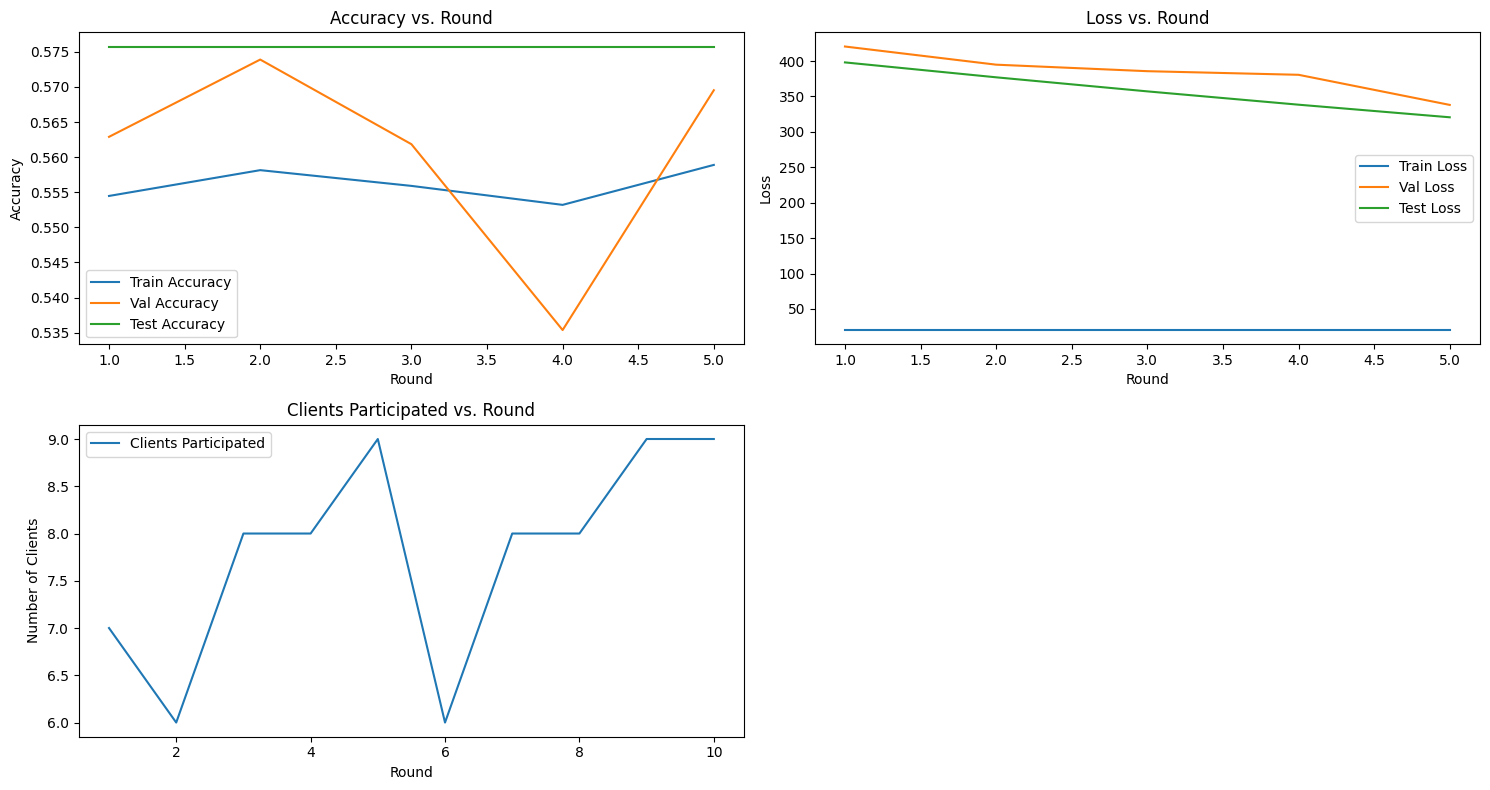

In [180]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ kết quả
plt.figure(figsize=(15, 8))

# Biểu đồ Accuracy
plt.subplot(2, 2, 1)
plt.plot(range(1, len(HISTORY["train_accuracy"]) + 1), HISTORY["train_accuracy"], label="Train Accuracy")
plt.plot(range(1, len(HISTORY["val_accuracy"]) + 1), HISTORY["val_accuracy"], label="Val Accuracy")
plt.plot(range(1, len(HISTORY["test_accuracy"]) + 1), HISTORY["test_accuracy"], label="Test Accuracy")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Round")
plt.legend()

# Biểu đồ Loss
plt.subplot(2, 2, 2)
plt.plot(range(1, len(HISTORY["train_loss"]) + 1), HISTORY["train_loss"], label="Train Loss")
plt.plot(range(1, len(HISTORY["val_loss"]) + 1), HISTORY["val_loss"], label="Val Loss")
plt.plot(range(1, len(HISTORY["test_loss"]) + 1), HISTORY["test_loss"], label="Test Loss")
plt.xlabel("Round")
plt.ylabel("Loss")
plt.title("Loss vs. Round")
plt.legend()

# Biểu đồ Clients Participated
plt.subplot(2, 2, 3)
plt.plot(range(1, len(HISTORY["clients_participated"]) + 1), HISTORY["clients_participated"], label="Clients Participated")
plt.xlabel("Round")
plt.ylabel("Number of Clients")
plt.title("Clients Participated vs. Round")
plt.legend()

plt.tight_layout()
plt.show()